### 导入包

In [1]:
import h5py
import numpy as np
import pandas as pd
import os
from PIL import Image
# import requests
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from collections import Counter

D:\anaconda\envs\nn6\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)
D:\anaconda\envs\nn6\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\anaconda\envs\nn6\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\envs\nn6\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

### 加载数据

In [2]:
def byte2str(data):
    data = list(data)
    for i, item in enumerate(data):
        data[i] = item.decode('utf-8')
    return data

def load_dataset(file_path):
    with h5py.File( file_path , 'r') as f:
        images = f['images']
        images = np.array(images)
        images = images.transpose((0, 3, 1, 2))
        images = images.astype('float32')
        images /= 255
        
        texts = byte2str(f['texts'])
        texts = np.array(texts)
        
        labels = byte2str(f['labels'])
        labels =  np.array(labels)
        
        label2id = {'negative': 0, 'neutral': 1, 'positive': 2}
        label_ids = [label2id[label] for label in labels]
        label_ids = np.array(label_ids)
        
        return images, texts, labels, label_ids
    
def load_exp_dataset(file_path):
    with h5py.File( file_path , 'r') as f:
        images = f['images']
        images = np.array(images)
        images = images.transpose((0, 3, 1, 2))
        images = images.astype('float32')
        images /= 255
        
        texts = byte2str(f['texts'])
        texts = np.array(texts)
        
        return images, texts

In [3]:
file_path = 'MVSA_Single/dataset.h5'
images, texts, labels, label_ids = load_dataset(file_path)
ori_images, ori_texts = images, texts

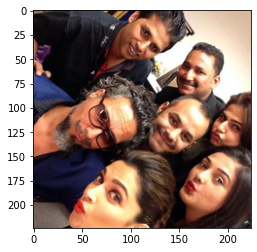

In [4]:
plt.imshow(ori_images[6].transpose(1, 2, 0))
plt.show()

In [3]:
exp_file_path = 'experiment.h5'
exp_images, exp_texts = load_exp_dataset(exp_file_path)
ori_exp_images , ori_exp_texts = exp_images, exp_texts

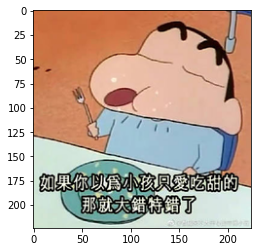

In [4]:
plt.imshow(ori_exp_images[119].transpose(1, 2, 0))
plt.show()

### 预处理文本

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def text2token(texts, maxlen):
    tokens = tokenizer.batch_encode_plus(texts,
                                         max_length=maxlen,
                                         padding='max_length',
                                         truncation=True,
                                         return_tensors='pt')
    input_ids = tokens['input_ids']
    return input_ids

In [ ]:
texts = text2token(texts,60)

In [7]:
exp_texts = text2token(exp_texts,60)

### ImageModel

In [8]:
class ImageModel(nn.Module):
    def __init__(self):
        super(ImageModel, self).__init__()
        #加载VGG16预训练模型
        self.vgg16 = models.vgg16(pretrained=True)
        # 去掉全连接层
        self.features = nn.Sequential(*list(self.vgg16.children())[:-1])
        # 冻结参数
        for param in self.features.parameters():
            param.requires_grad = False
        # 添加新的全连接层以便训练任务
        self.fc = nn.Linear(512 * 7 * 7, 256)
        self.to('cuda')
        
    def forward(self, x_image):
        # 将图像作为VGG16的输入
        features = self.features(x_image)
        # 将输出的特征展开
        flatten = nn.Flatten()(features)
        # 用全连接层提取特征
        fc_out = self.fc(flatten)
        return fc_out

### TextModel

In [9]:
class TextModel(nn.Module):
    def __init__(self, model_name):
        super(TextModel, self).__init__()
        # 加载预训练模型和tokenizer
        self.embedding = BertModel.from_pretrained(model_name)
#         # 定义线性层，用于输出分类结果
#         self.fc = nn.Linear(self.embedding.config.hidden_size, num_classes)
        self.fc = nn.Linear(768, 256)
        self.to('cuda')
    
    def forward(self, x):
        input_ids = x
        # 获取BERT编码特征
        with torch.no_grad():
            embedding_output = self.embedding(input_ids=input_ids)[0]
            # 取最后一层的输出作为特征表示
            features = embedding_output[:, 0, :]
        fc_out = self.fc(features)
#         # 使用全连接层进行分类
#         logits = self.fc(features)
#         return logits
        return fc_out

### FusionModel

In [10]:
class FusionModel(nn.Module):
    def __init__(self, model_name, num_classes, dropout_prob = 0.5):
        super(FusionModel, self).__init__()
        self.num_classes = num_classes
        self.TextModel = TextModel(model_name=model_name)
        self.ImageModel = ImageModel()
        # 定义融合后的全连接层
        self.fusion_fc = nn.Sequential(
            nn.Linear(256 + 256, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(128, num_classes)
        )
        self.to('cuda')
        
    def forward(self, x):
        x_image = x['image']
        x_text = x['text']
        feature_image_out = self.ImageModel(x_image)
        feature_text_out = self.TextModel(x_text)
        #将文本特征和图像特征拼接在一起
        fusion_fea = torch.cat((feature_image_out, feature_text_out), dim=1)
        # 对融合后的特征进行全连接层操作
        y_pred = self.fusion_fc(fusion_fea)
        return y_pred

### 实例化模型

In [11]:
MyModel = FusionModel(model_name='bert-base-uncased', num_classes=3).to('cuda')

### 定义Dataset类

In [13]:
class Dataset(Dataset):
    def __init__(self, images, texts, label_ids):
        self.images = images
        self.texts = texts
        self.label_ids = label_ids
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        text = self.texts[idx]
        label_id = self.label_ids[idx]
        return image, text, label_id

### 定义优化器对象

In [14]:
criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = optim.Adam(MyModel.parameters(), lr=0.001\
                       , weight_decay=0.00001\
                      )

### 初始化参数

In [15]:
batch_size = 32
num_epochs = 24
split_ratio = 0.2
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

In [45]:
for epoch in range(num_epochs):
    np.random.seed(epoch)

    train_images, test_images, \
    train_texts, test_texts, \
    train_label_ids, test_label_ids = \
    train_test_split(images, texts, label_ids, test_size = split_ratio)

    # 创建数据集对象
    train_dataset = Dataset(train_images, train_texts, train_label_ids)
    test_dataset = Dataset(test_images, test_texts, test_label_ids)

     # 创建数据加载器对象
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    MyModel.train()
    train_loss = 0.0
    train_total = 0
    train_correct = 0
    i = 0
    for image, text, label_id in train_loader:
        i += 1
        image = image.to('cuda')
        text = text.to('cuda')
        label_id = label_id.long()
        label_id = label_id.to('cuda')
        
        optimizer.zero_grad()
        outputs = MyModel({'image' : image, 'text' : text})
        loss = criterion(outputs, label_id)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        train_total += label_id.size(0)
        train_correct += (predicted == label_id).sum().item()
        train_loss += loss.item() * label_id.size(0)
#         if i % 4 ==3:
#             train_loss_list.append(loss.item())
        
        if i % 20 == 19:
            print('Train：[%d, %5d] loss: %.3f, accuracy: %.3f' %
                  (epoch + 1, i + 1, train_loss / train_total, train_correct / train_total))
            train_acc_list.append(train_correct / train_total)
            train_loss_list.append(train_loss / train_total)
#             train_loss_list.append(loss.item() * label_id.size(0))
#             train_loss = 0.0    

    train_acc = train_correct / train_total
    
    MyModel.eval()
    test_loss = 0.0
    test_total = 0
    test_correct = 0
    i = 0
    with torch.no_grad():
         for image, text, label_id in test_loader:
            i += 1    
            image = image.to('cuda')
            text = text.to('cuda')
            label_id = label_id.long()
            label_id = label_id.to('cuda')
            outputs = MyModel({'image' : image, 'text' : text})
            loss = criterion(outputs, label_id)
            
            _, predicted = torch.max(outputs.data, 1)
            test_total += label_id.size(0)
            test_correct += (predicted == label_id).sum().item()
            test_loss += loss.item() * label_id.size(0)
            
#             test_loss_list.append(loss.item())
            
            if i % 5 == 4:
                print('Test：[%d, %5d] loss: %.3f, accuracy: %.3f' %
                      (epoch + 1, i + 1, test_loss / test_total, test_correct / test_total))
                test_acc_list.append(test_correct / test_total)
                test_loss_list.append(test_loss / test_total)
#                 test_loss_list.append(loss.item() * label_id.size(0))
#                 test_loss = 0.0    


Train：[1,    20] loss: 1.363, accuracy: 0.362
Train：[1,    40] loss: 1.228, accuracy: 0.390
Train：[1,    60] loss: 1.178, accuracy: 0.397
Train：[1,    80] loss: 1.157, accuracy: 0.387
Train：[1,   100] loss: 1.143, accuracy: 0.389
Train：[1,   120] loss: 1.135, accuracy: 0.392
Test：[1,     5] loss: 1.069, accuracy: 0.469
Test：[1,    10] loss: 1.081, accuracy: 0.399
Test：[1,    15] loss: 1.084, accuracy: 0.402
Test：[1,    20] loss: 1.084, accuracy: 0.400
Test：[1,    25] loss: 1.084, accuracy: 0.414
Test：[1,    30] loss: 1.084, accuracy: 0.418
Train：[2,    20] loss: 1.079, accuracy: 0.406
Train：[2,    40] loss: 1.073, accuracy: 0.423
Train：[2,    60] loss: 1.062, accuracy: 0.433
Train：[2,    80] loss: 1.059, accuracy: 0.436
Train：[2,   100] loss: 1.062, accuracy: 0.434
Train：[2,   120] loss: 1.059, accuracy: 0.443
Test：[2,     5] loss: 0.955, accuracy: 0.578
Test：[2,    10] loss: 0.975, accuracy: 0.531
Test：[2,    15] loss: 0.972, accuracy: 0.565
Test：[2,    20] loss: 0.974, accuracy: 0.56

Test：[15,    30] loss: 0.119, accuracy: 0.953
Train：[16,    20] loss: 0.159, accuracy: 0.944
Train：[16,    40] loss: 0.160, accuracy: 0.948
Train：[16,    60] loss: 0.162, accuracy: 0.949
Train：[16,    80] loss: 0.178, accuracy: 0.942
Train：[16,   100] loss: 0.189, accuracy: 0.938
Train：[16,   120] loss: 0.194, accuracy: 0.936
Test：[16,     5] loss: 0.071, accuracy: 0.984
Test：[16,    10] loss: 0.147, accuracy: 0.944
Test：[16,    15] loss: 0.116, accuracy: 0.958
Test：[16,    20] loss: 0.124, accuracy: 0.954
Test：[16,    25] loss: 0.126, accuracy: 0.953
Test：[16,    30] loss: 0.117, accuracy: 0.957
Train：[17,    20] loss: 0.106, accuracy: 0.957
Train：[17,    40] loss: 0.118, accuracy: 0.954
Train：[17,    60] loss: 0.157, accuracy: 0.945
Train：[17,    80] loss: 0.169, accuracy: 0.941
Train：[17,   100] loss: 0.179, accuracy: 0.938
Train：[17,   120] loss: 0.183, accuracy: 0.938
Test：[17,     5] loss: 0.256, accuracy: 0.945
Test：[17,    10] loss: 0.183, accuracy: 0.955
Test：[17,    15] loss:

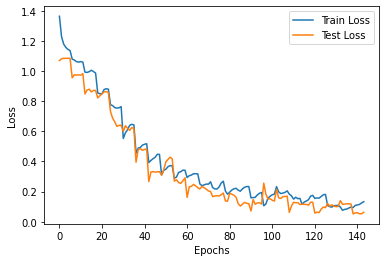

<function matplotlib.pyplot.show(close=None, block=None)>

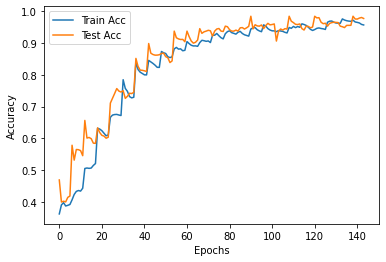

In [46]:
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_acc_list, label='Train Acc')
plt.plot(test_acc_list, label='Test Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show

In [ ]:
model_path = "2.pt"
torch.save(MyModel.state_dict(), model_path)

In [12]:
checkpoint = torch.load('2.pt')
MyModel.load_state_dict(checkpoint)

<All keys matched successfully>

In [13]:
result_list = []
image_features = []
text_features = []
text_bert = []
embedding_layer = MyModel.TextModel.embedding
for i in range(len(exp_texts)):
    with torch.no_grad():
        current_image = torch.from_numpy(exp_images[i]).unsqueeze(0).to('cuda')
        current_text = exp_texts[i].unsqueeze(0).to('cuda')
        input_data = {'image': current_image, 'text': current_text}
        model_output = MyModel(input_data)
        image_features.append(MyModel.ImageModel(current_image))
        text_features.append(MyModel.TextModel(current_text))
        embeddings = embedding_layer(current_text)[0]
        text_bert.append(embeddings)

    # 计算预测概率
    probabilities = torch.softmax(model_output, dim=1)
    # 获取预测类别
    predicted_class = torch.argmax(probabilities, dim=1).item()
    result_list.append(predicted_class)
    
    # 输出预测结果
#     print("Predicted class:", predicted_class)    

In [18]:
exp_texts[119]

tensor([ 101,  100,  100, 1903,  100, 1916,  100,  100,  100,  100, 1855,  100,
         100, 1849,  100,  100,  100,  102,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])

In [19]:
exp_images[119]

array([[[0.80784315, 0.80784315, 0.8039216 , ..., 0.23921569,
         0.24313726, 0.24313726],
        [0.80784315, 0.80784315, 0.8039216 , ..., 0.1882353 ,
         0.22352941, 0.23137255],
        [0.80784315, 0.80784315, 0.8039216 , ..., 0.11372549,
         0.12156863, 0.12156863],
        ...,
        [0.8156863 , 0.8156863 , 0.8156863 , ..., 0.80784315,
         0.85882354, 0.8745098 ],
        [0.80784315, 0.80784315, 0.80784315, ..., 0.84313726,
         0.8666667 , 0.8745098 ],
        [0.8       , 0.8       , 0.8       , ..., 0.8745098 ,
         0.85882354, 0.8666667 ]],

       [[0.43529412, 0.43529412, 0.43137255, ..., 0.38039216,
         0.3882353 , 0.3882353 ],
        [0.43529412, 0.43529412, 0.43137255, ..., 0.2627451 ,
         0.30980393, 0.32156864],
        [0.43529412, 0.43529412, 0.43137255, ..., 0.18039216,
         0.20784314, 0.21176471],
        ...,
        [0.8980392 , 0.8980392 , 0.8980392 , ..., 0.87058824,
         0.92156863, 0.9372549 ],
        [0.9

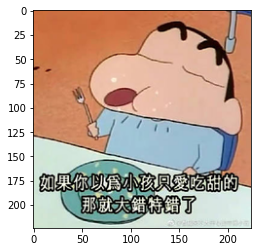

In [23]:
plt.imshow(exp_images[119].transpose(1, 2, 0))
plt.show()

In [20]:
text_bert[119]

tensor([[[-0.1555,  0.2005,  0.3834,  ..., -0.1903,  0.6056, -0.4107],
         [-0.3095, -0.0872,  0.7275,  ..., -0.2379,  0.5542, -0.4257],
         [-0.6172, -0.0442,  0.8275,  ..., -0.3056,  0.0979, -0.6117],
         ...,
         [-0.0511, -0.1365,  0.9218,  ..., -0.4810,  0.1087, -0.4905],
         [-0.0061, -0.1978,  0.9092,  ..., -0.4439,  0.1125, -0.5050],
         [ 0.0079, -0.2241,  0.8558,  ..., -0.4370,  0.1599, -0.5266]]],
       device='cuda:0')

In [21]:
text_features[119]

tensor([[-0.1220,  0.1413, -0.3058, -0.0493,  0.1004,  0.0689, -0.0311,  0.1358,
          0.2123,  0.2064, -0.4712,  0.5449,  0.1147, -0.4748,  0.0248, -0.3287,
          0.3883, -0.0048, -0.0839, -0.2308,  0.0050,  0.0184, -0.2584,  0.2208,
          0.0924,  0.0257, -0.2431,  0.1285,  0.1867,  0.4888,  0.0481,  0.6788,
         -0.3821, -0.1126,  0.1065,  0.1606,  0.2856, -0.1366,  0.3088, -0.3272,
         -0.0840,  0.0125,  0.1681,  0.5743, -0.1587,  0.1178, -0.3530,  0.0451,
          0.2590, -0.2283,  0.1163, -0.1963,  0.0565,  0.0403, -0.5145,  0.1852,
         -0.0815, -0.4833, -0.1364,  0.1472, -0.3770,  0.2804,  0.1019, -0.3151,
          0.0134,  0.0474, -0.0091,  0.4902, -0.3530, -0.5294, -0.1528, -0.1292,
          0.4349,  0.0695, -0.6589, -0.2088,  0.2069,  0.1867, -0.1883,  0.4304,
         -0.0266,  0.1400, -0.2613,  0.0754, -0.0494, -0.2399,  0.3604,  0.7136,
         -0.1665, -0.0207, -0.5009, -0.2730,  0.1163,  0.0915,  0.1977, -0.2843,
          0.2107,  0.1052,  

In [22]:
image_features[119]

tensor([[-0.3158,  0.1694, -0.2355, -0.0495, -0.1831,  0.4438, -0.2368,  0.1480,
         -0.3731, -0.3449, -0.5622,  0.1557,  0.1803, -0.3523,  0.2363,  0.3759,
          0.9733,  0.5566,  0.5714, -0.1417, -0.0775, -0.2735,  0.1594, -0.5525,
         -0.1005, -0.1189, -0.0581,  0.2768,  0.1645, -0.4214, -0.0027, -0.2647,
         -0.0461,  0.0873, -0.1688, -0.0873,  0.1100, -0.3114,  0.2948, -0.2222,
          0.2409,  0.4928, -0.0641,  0.1717, -0.1203, -0.4987, -0.0765,  0.8014,
         -0.8136,  0.0729, -0.1765, -0.3716, -0.5780,  0.5050,  0.2501,  0.2994,
         -0.4475,  0.1515,  0.4844,  0.3148,  0.0291,  0.1507,  0.1061,  0.6178,
         -0.4176,  0.6193,  0.9356, -0.0361, -1.0846, -0.3029, -0.2836, -0.1523,
          0.3793,  0.0346, -0.0965,  0.1888, -0.4888, -0.3254,  0.4645, -0.3048,
         -0.4587,  0.1640, -0.4666,  0.4086,  0.3654,  0.3309,  0.0857,  0.2042,
         -0.4453, -0.1505,  0.9027,  0.2981, -0.6145, -0.1118,  0.2334,  0.2654,
         -0.0633, -0.2832,  

In [18]:
def id2result(list): 
#     id2result = {0:'negative', 1:'neutral', 2:'positive'}
    id2result = {0: '厌恶', 1: '综合', 2: '积极'}
    result = [id2result[i] for i in list]
    return result
result = id2result(result_list)

In [19]:
counter = Counter(result_list)
print(counter)

Counter({0: 95, 2: 26, 1: 16})



样本  119  
其文本为：“看到清醒的友友很多我就放心了😌 ​”，
情感分类标签是：  0  ，
情感分类结果是:   厌恶   ，
它的图片如下：


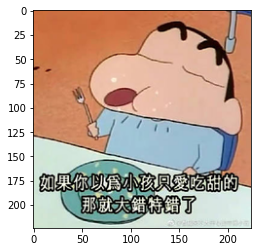

In [39]:
sample_index = 119
# 输出文本分类结果
print(f"\n样本  {sample_index}  "
      f"\n其文本为：“{ori_exp_texts[sample_index]}”，"
      f"\n情感分类标签是：  {result_list[sample_index]}  ，"
      f"\n情感分类结果是:   {result[sample_index]}   ，"
      f"\n它的图片如下：")
# 加载并展示对应的图片
plt.imshow(ori_exp_images[sample_index].transpose(1, 2, 0))
plt.show()


样本  1  
其文本为：“帽子戴的多了，根本不在意再多一个。 ​”，
情感分类标签是：  0  ，
情感分类结果是:   厌恶   ，
它的图片如下：


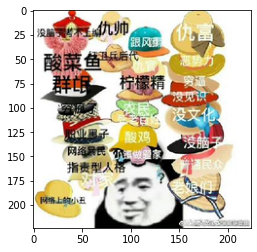

In [55]:
sample_index = 1
# 输出文本分类结果
print(f"\n样本  {sample_index}  "
      f"\n其文本为：“{ori_exp_texts[sample_index]}”，"
      f"\n情感分类标签是：  {result_list[sample_index]}  ，"
      f"\n情感分类结果是:   {result[sample_index]}   ，"
      f"\n它的图片如下：")
# 加载并展示对应的图片
plt.imshow(ori_exp_images[sample_index].transpose(1, 2, 0))
plt.show()

In [42]:
total_length = sum(len(text) for text in ori_exp_texts)
average_length = total_length / len(ori_exp_texts)

print("Average text length:", average_length)


Average text length: 53.59124087591241


In [49]:
for i in range(30):
    result_list2 = []
    for i in range(len(exp_texts)):
        with torch.no_grad():
            current_image = torch.from_numpy(exp_images[i]).unsqueeze(0).to('cuda')
            current_text = exp_texts[i].unsqueeze(0).to('cuda')
            input_data = {'image': current_image, 'text': current_text}
            model_output = MyModel(input_data)

        # 计算预测概率
        probabilities = torch.softmax(model_output, dim=1)
        # 获取预测类别
        predicted_class = torch.argmax(probabilities, dim=1).item()
        result_list2.append(predicted_class)

        # 输出预测结果
    #     print("Predicted class:", predicted_class)    
    result2 = id2result(result_list2)
    counter2 = Counter(result_list2)
    print(counter2)

Counter({0: 103, 2: 20, 1: 14})
Counter({0: 103, 2: 25, 1: 9})
Counter({0: 111, 2: 20, 1: 6})
Counter({0: 108, 2: 24, 1: 5})
Counter({0: 107, 2: 23, 1: 7})
Counter({0: 102, 2: 25, 1: 10})
Counter({0: 112, 2: 16, 1: 9})
Counter({0: 109, 2: 19, 1: 9})
Counter({0: 97, 2: 26, 1: 14})
Counter({0: 106, 2: 21, 1: 10})
Counter({0: 107, 2: 23, 1: 7})
Counter({0: 111, 2: 16, 1: 10})
Counter({0: 99, 2: 28, 1: 10})
Counter({0: 96, 2: 24, 1: 17})
Counter({0: 114, 2: 16, 1: 7})
Counter({0: 106, 2: 19, 1: 12})
Counter({0: 108, 2: 19, 1: 10})
Counter({0: 106, 2: 21, 1: 10})
Counter({0: 99, 2: 26, 1: 12})
Counter({0: 103, 2: 28, 1: 6})
Counter({0: 105, 2: 23, 1: 9})
Counter({0: 107, 2: 16, 1: 14})
Counter({0: 98, 2: 29, 1: 10})
Counter({0: 99, 2: 31, 1: 7})
Counter({0: 100, 2: 23, 1: 14})
Counter({0: 100, 2: 23, 1: 14})
Counter({0: 102, 2: 24, 1: 11})
Counter({0: 103, 2: 24, 1: 10})
Counter({0: 99, 2: 30, 1: 8})
Counter({0: 95, 2: 34, 1: 8})



样本  136  
其文本为：“把月亮挂好，把星星点亮，准备入睡，晚安 ​”，
情感分类标签是：  2  ，
情感分类结果是:   积极   ，
它的图片如下：


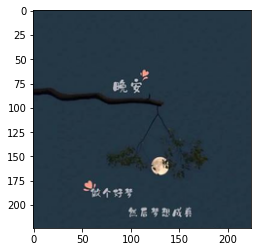

In [76]:
sample_index2 = 136
# 输出文本分类结果
print(f"\n样本  {sample_index2}  "
      f"\n其文本为：“{ori_exp_texts[sample_index2]}”，"
      f"\n情感分类标签是：  {result_list2[sample_index2]}  ，"
      f"\n情感分类结果是:   {result2[sample_index2]}   ，"
      f"\n它的图片如下：")
# 加载并展示对应的图片
plt.imshow(ori_exp_images[sample_index2].transpose(1, 2, 0))
plt.show()

In [71]:
for i in range(len(result_list2)):
    print(result_list2[i])

0
0
1
0
0
0
2
0
0
0
0
0
1
0
0
0
0
2
0
0
0
0
0
0
2
2
0
0
0
0
0
2
0
0
0
0
0
2
0
0
0
0
2
0
2
1
0
0
2
0
0
2
0
2
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2
2
1
2
0
0
2
0
0
0
0
2
2
1
0
0
0
2
0
2
2
0
0
0
0
2
1
2
0
2
0
0
0
2
0
0
0
0
0
0
2
0
0
2
2
0
0
2
0
0
0
0
2
0
0
0
0
2
0
0
0
1
2
1
0
2
